In [4]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, zscore
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(cowplot)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to Pearson correlation

In [6]:
data_path = "/Users/abry4213/data/HCP100/"

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)
pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

all_pearson_res_with_HoFC = (HCP_avg_Pearson_FC
 .assign(Connection_Type = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 'Homotopic', np.where(x.Hemi_From==x.Hemi_To, 'Intra-hemispheric', 'Inter-hemispheric')))
 .groupby(['Base_Region_From', 'Base_Region_To', 'Connection_Type'])['Mean_Pearson_R']
    .mean()
    .reset_index()
)


#### GROUP-AVERAGED STRUCTURAL CONNECTOME FROM ENIGMA #### 
sc_ctx, sc_ctx_labels, _, _ = load_sc(parcellation='aparc')

HCP_avg_Pearson_SC = (pd.DataFrame(sc_ctx, columns=sc_ctx_labels)
                      .assign(Brain_Region_From = sc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Num_Streamlines")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

SC_homotopic_res_mean = (HCP_avg_Pearson_SC
                            .query("Base_Region_From == Base_Region_To")
                            .groupby(["Base_Region_From"])['Mean_Num_Streamlines']
                            .mean() 
                            .reset_index()
                            .rename(columns={"Base_Region_From": "Base_Region"})
                            .rename(columns={"Mean_Num_Streamlines": "Value"})
                            .assign(Category = "Microstructure", Description = "Log-SC")
                            )

# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

mean_SC_degree_per_region = (HCP_avg_Pearson_SC
                             .assign(Connection_Type = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 'Homotopic', np.where(x.Hemi_From==x.Hemi_To, 'Intra-hemispheric', 'Inter-hemispheric')))
                             .groupby(['Base_Region_From', 'Connection_Type'])['Mean_Num_Streamlines']
                             .mean()
                             .reset_index()
)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


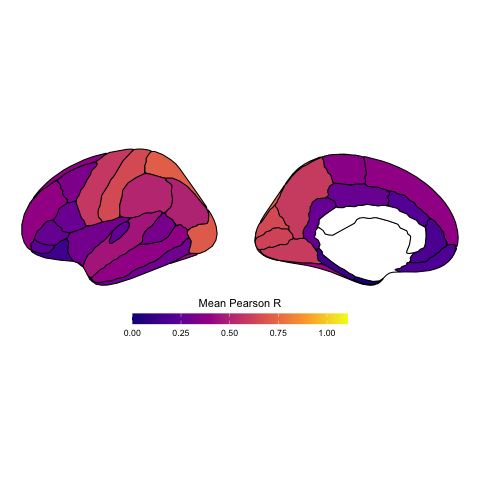

In [10]:
%%R -i pearson_homotopic_res_mean,all_pearson_res_with_HoFC

min_fill <- min(all_pearson_res_with_HoFC$Mean_Pearson_R)
max_fill <- max(all_pearson_res_with_HoFC$Mean_Pearson_R)

### Pearson FC in brain ###
pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.5) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white", option='plasma', limits=c(min_fill, max_fill)) +
  theme(plot.title = element_blank(),
            legend.key.width  = unit(3, "lines"),
            legend.key.height  = unit(0.75, "lines"),
            legend.position = "bottom") +
            guides(fill = guide_colorbar(title.position="top", title.hjust=0.5))
# ggsave("../plots/network_topology/Mean_homotopic_FC_plasma_colors_brain.svg", width=5, height=3, units='in', dpi=300)

In [11]:
# Find the order based on pearson_homotopic_res_mean
region_order_HoFC = pearson_homotopic_res_mean.sort_values(by='Mean_Pearson_R', ascending=True).Base_Region.tolist()

# Make a correlation matrix where the diagonal is values corresponding to Connection_Type=='Homotopic', 
# the lower triangle to Connection_Type=='Intra-hemispheric', and the upper triangle to Connection_Type=='Inter-hemispheric'

# Get unique regions
regions = sorted(set(all_pearson_res_with_HoFC["Base_Region_From"]).union(set(all_pearson_res_with_HoFC["Base_Region_To"])))

# Create empty square dataframe
pearson_corr_conn_matrix = pd.DataFrame(np.nan, index=regions, columns=regions)

# Fill matrix based on connection type
for _, row in all_pearson_res_with_HoFC.iterrows():
    src, tgt, conn_type, value = row["Base_Region_From"], row["Base_Region_To"], row["Connection_Type"], row["Mean_Pearson_R"]
    
    if src == tgt and conn_type == "Homotopic":
        pearson_corr_conn_matrix.loc[src, tgt] = value  # Diagonal
    elif src != tgt:
        # Sort to determine upper/lower placement
        region1, region2 = sorted([src, tgt])

        if conn_type == "Intra-hemispheric":
            pearson_corr_conn_matrix.loc[region2, region1] = value  # Lower triangle
        elif conn_type == "Inter-hemispheric":
            pearson_corr_conn_matrix.loc[region1, region2] = value  # Upper triangle

# Sort the rows and columns based on AHBA_PC1_based_hierarchy_order
pearson_corr_conn_matrix = pearson_corr_conn_matrix.loc[region_order_HoFC, region_order_HoFC]

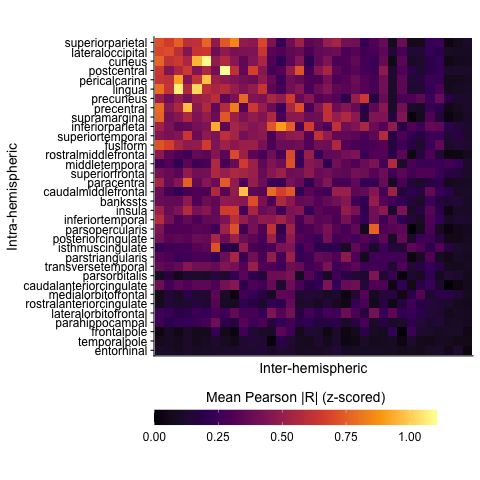

In [12]:
%%R -i pearson_corr_conn_matrix,region_order_HoFC

pearson_corr_conn_matrix %>% 
    mutate(region_1 = rownames(.)) %>%
    pivot_longer(-region_1, names_to="region_2", values_to="Mean_Pearson_R") %>%
    mutate(region_1 = factor(region_1, levels=region_order_HoFC),
           region_2 = factor(region_2, levels=region_order_HoFC)) %>%
    ggplot(data=., mapping=aes(x=region_1, y=region_2, fill=Mean_Pearson_R)) +
    geom_tile() +
    scale_fill_viridis_c(option='inferno') +
    ylab("Intra-hemispheric") +
    xlab("Inter-hemispheric") +
    labs(fill="Mean Pearson |R| (z-scored)") +
    scale_x_discrete(limits=rev) +
    coord_equal() +
    guides(fill=guide_colorbar(title.position="top", title.hjust=0.5)) +
    theme(legend.position='bottom',
          legend.key.width=unit(2, "cm"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
# ggsave("../plots/network_topology/Connection_type_degree_FC_matrix.svg", width=6, height=5.5, units="in", dpi=300)

## Does HoFC correlate with a region's overall degree?

In [15]:
%%R -i all_pearson_res_with_HoFC,all_pearson_res_with_HoFC

min_fill <- min(all_pearson_res_with_HoFC$Mean_Pearson_R)
max_fill <- max(all_pearson_res_with_HoFC$Mean_Pearson_R)

all_pearson_res_with_HoFC %>%
    group_by(Base_Region_From) %>% 
    summarise(HoFC_degree = mean(Mean_Pearson_R[Connection_Type == "Homotopic"]),
              Intra_hem_degree = mean(Mean_Pearson_R[Connection_Type == "Intra-hemispheric"]),
              Inter_hem_degree = mean(Mean_Pearson_R[Connection_Type == "Inter-hemispheric"])) %>%
    ungroup() %>%
    pivot_longer(c(Intra_hem_degree, Inter_hem_degree), names_to="Connectivity_Type", values_to="non_HoFC_degree") %>%
    mutate(Connectivity_Type = factor(Connectivity_Type, levels=c("Intra_hem_degree", "Inter_hem_degree"))) %>%
    ggplot(data=., mapping=aes(x=non_HoFC_degree, y=HoFC_degree, fill=HoFC_degree)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c(option='plasma', limits=c(min_fill, max_fill)) +
    xlab("Non-homotopic average FC") +
    ylab("Homotopic FC") +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    facet_wrap(Connectivity_Type ~ ., nrow=1) +
    theme(legend.position='none',
          strip.background = element_blank())

ggsave("../plots/network_topology/HoFC_vs_other_degree_scatters.svg", width=6, height=3.35, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
4: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping

## Does HoFC exceed other functional connections within/across hemispheres?

In [17]:
%%R -i all_pearson_res_with_HoFC,all_pearson_res_with_HoFC

min_fill <- min(all_pearson_res_with_HoFC$Mean_Pearson_R)
max_fill <- max(all_pearson_res_with_HoFC$Mean_Pearson_R)

homotopic_subset = all_pearson_res_with_HoFC %>% filter(Connection_Type == "Homotopic") 
region_order <- homotopic_subset %>% arrange(desc(Mean_Pearson_R)) %>% pull(Base_Region_From)

homotopic_subset <- homotopic_subset %>% 
    mutate(Base_Region_From = factor(Base_Region_From, levels=region_order)) 

all_pearson_res_with_HoFC <- all_pearson_res_with_HoFC %>%
    mutate(Base_Region_From = factor(Base_Region_From, levels=region_order)) %>% 
    group_by(Base_Region_From) %>%
    mutate(Homotopic_Fill = mean(Mean_Pearson_R[Connection_Type == "Homotopic"]))

intra_hemispheric_data <- all_pearson_res_with_HoFC %>% filter(Connection_Type == "Intra-hemispheric")
inter_hemispheric_data <- all_pearson_res_with_HoFC %>% filter(Connection_Type == "Inter-hemispheric")

ggplot() +
    geom_violinhalf(data=intra_hemispheric_data, 
        aes(x=Base_Region_From, y=Mean_Pearson_R, fill=Homotopic_Fill), scale='width') +
    geom_violinhalf(data=inter_hemispheric_data, 
        aes(x=Base_Region_From, y=Mean_Pearson_R, fill=Homotopic_Fill), flip=TRUE,
        scale='width') +
    stat_summary(data=homotopic_subset, mapping=aes(x=Base_Region_From, y=Mean_Pearson_R),
                 color="black", fun="mean", geom="crossbar", width=1, linewidth=0.3, show.legend=FALSE) +
    scale_fill_viridis_c(option='plasma', limits=c(min_fill, max_fill)) +
    scale_y_continuous(expand=c(0,0)) +
    ylab("Mean Pearson FC (z-scored)") +
    xlab("Cortical regions, ordered by HoFC") +
    theme(legend.position='none',
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
# ggsave("../plots/network_topology/HoFC_vs_all_other_FC_violins.svg", width=7.5, height=2.5, units="in", dpi=300)